In [1]:
import hft
# import filegetter.filegetter as fgt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import pearsonr,spearmanr



from hft.utils.wrapper import trade_to_depth
from hft.utils.validate import plot_stats
from hft.utils.target.mid_price_changes import all_return
from hft.utils.target import filled_return, mid_price_changes, mp_changes
from hft.utils.combine import linear_model, SGDlinear_model
from hft.utils.format import purged_train_test_split, single_split
from hft.utils.format import depth_to_depth

from hft.signal import arrive_rate, depth_age, depth_changes, fair_spread, large_jump, oir, price_distance, volume, weakoir, return_lag, order_flow 

ob=pd.read_hdf('BINANCE_SWAP_BTC-USDT_DEPTH5_2022_02_28.hdf', key="data")   #订单簿，包括买卖意向，各时刻都存在
tr=pd.read_hdf('BINANCE_SWAP_BTC-USDT_TRADE_2022_02_28.hdf', key="data")    #实际交易数据

In [2]:
ob

,bid1_price,bid1_vol,ask1_price,ask1_vol,bid2_price,bid2_vol,ask2_price,ask2_vol,bid3_price,bid3_vol,...,bid4_price,bid4_vol,ask4_price,ask4_vol,bid5_price,bid5_vol,ask5_price,ask5_vol,time,local_time
0,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.6,0.007,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.7,0.014,37675.1,0.359,1646006398926,1646006398926
1,37672.6,0.020,37672.7,0.126,37672.1,0.082,37674.6,0.007,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.2,0.020,37675.1,0.359,1646006398959,1646006398959
2,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.6,0.279,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.2,0.020,37675.1,0.359,1646006398993,1646006398993
3,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.5,0.011,37672.0,1.151,...,37670.9,0.333,37674.9,0.067,37670.2,0.020,37675.0,1.000,1646006399029,1646006399029
4,37672.1,0.176,37672.2,1.418,37672.0,1.151,37672.5,0.216,37670.9,0.333,...,37670.0,0.001,37674.4,0.067,37669.4,0.014,37674.5,0.011,1646006399067,1646006399067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521495,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.9,0.021,43162.4,3.297,43155.9,0.075,43162.5,0.544,1646092798840,1646092798840
2521496,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.0,0.021,43162.4,3.297,43155.9,0.075,43162.5,0.544,1646092798880,1646092798880
2521497,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.2,0.008,43162.4,3.297,43156.0,0.021,43162.5,0.544,1646092798913,1646092798913
2521498,43160.8,0.001,43160.9,4.447,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.2,0.008,43162.4,3.271,43156.0,0.021,43162.5,0.004,1646092798946,1646092798946


In [3]:
tr

,price,vol,time,local_time
0,37672.1,0.040,1646006399296,1646006399296
1,37672.0,-0.154,1646006399522,1646006399522
2,37672.0,-0.197,1646006399673,1646006399673
3,37672.0,-1.425,1646006399826,1646006399826
4,37672.0,-0.017,1646006399982,1646006399982
...,...,...,...,...
2951815,43159.9,-0.045,1646092799188,1646092799188
2951816,43160.0,0.925,1646092799339,1646092799339
2951817,43160.0,0.017,1646092799510,1646092799510
2951818,43160.0,0.344,1646092799639,1646092799639


In [4]:
ob.columns

Index(['bid1_price', 'bid1_vol', 'ask1_price', 'ask1_vol', 'bid2_price',
       'bid2_vol', 'ask2_price', 'ask2_vol', 'bid3_price', 'bid3_vol',
       'ask3_price', 'ask3_vol', 'bid4_price', 'bid4_vol', 'ask4_price',
       'ask4_vol', 'bid5_price', 'bid5_vol', 'ask5_price', 'ask5_vol', 'time',
       'local_time'],
      dtype='object')

In [5]:
#rename
ob = ob.rename(columns={'bid1_price':'bp1','ask1_price':'ap1','bid1_vol':'bv1', 'ask1_vol':'av1', 'bid2_price':'bp2',
       'bid2_vol':'bv2', 'ask2_price':'ap2', 'ask2_vol':'av2', 'bid3_price':'bp3', 'bid3_vol':'bv3',
       'ask3_price':'ap3', 'ask3_vol':'av3', 'bid4_price':'bp4', 'bid4_vol':'bv4', 'ask4_price':'ap4',
       'ask4_vol':'av4', 'bid5_price':'bp5', 'bid5_vol':'bv5', 'ask5_price':'ap5', 'ask5_vol':'av5',
       'time':'ts'})
tr = tr.rename(columns={'time':'ts','price':'p','vol':'v'})
ob

,bp1,bv1,ap1,av1,bp2,bv2,ap2,av2,bp3,bv3,...,bp4,bv4,ap4,av4,bp5,bv5,ap5,av5,ts,local_time
0,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.6,0.007,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.7,0.014,37675.1,0.359,1646006398926,1646006398926
1,37672.6,0.020,37672.7,0.126,37672.1,0.082,37674.6,0.007,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.2,0.020,37675.1,0.359,1646006398959,1646006398959
2,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.6,0.279,37672.0,1.151,...,37670.9,0.333,37675.0,1.000,37670.2,0.020,37675.1,0.359,1646006398993,1646006398993
3,37672.6,0.020,37672.7,0.126,37672.1,0.180,37674.5,0.011,37672.0,1.151,...,37670.9,0.333,37674.9,0.067,37670.2,0.020,37675.0,1.000,1646006399029,1646006399029
4,37672.1,0.176,37672.2,1.418,37672.0,1.151,37672.5,0.216,37670.9,0.333,...,37670.0,0.001,37674.4,0.067,37669.4,0.014,37674.5,0.011,1646006399067,1646006399067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521495,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.9,0.021,43162.4,3.297,43155.9,0.075,43162.5,0.544,1646092798840,1646092798840
2521496,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.0,0.021,43162.4,3.297,43155.9,0.075,43162.5,0.544,1646092798880,1646092798880
2521497,43160.8,0.001,43160.9,4.047,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.2,0.008,43162.4,3.297,43156.0,0.021,43162.5,0.544,1646092798913,1646092798913
2521498,43160.8,0.001,43160.9,4.447,43159.9,0.273,43162.1,0.046,43159.1,0.004,...,43156.2,0.008,43162.4,3.271,43156.0,0.021,43162.5,0.004,1646092798946,1646092798946


### Target

In [6]:
mid_price_ = (ob.ap1 + ob.bp1)/2        #特定股票的买入价和卖出价之间的平均价格

In [7]:
mid_price_

0          37672.65
1          37672.65
2          37672.65
3          37672.65
4          37672.15
             ...   
2521495    43160.85
2521496    43160.85
2521497    43160.85
2521498    43160.85
2521499    43160.85
Length: 2521500, dtype: float64

In [8]:
#vaule of target
mid_price_.diff(500).shift(-500).fillna(0)    #dif相减，shift平移，fillna填充缺失数据

0          4.1
1          4.1
2          4.1
3          4.1
4          4.6
          ... 
2521495    0.0
2521496    0.0
2521497    0.0
2521498    0.0
2521499    0.0
Length: 2521500, dtype: float64

### 因子1：bid_age

In [9]:
import numpy as np
import pandas as pd
import numba as nb

@nb.jit
def get_age(x):
    last_value = x[-1]             
    age = 0
    for i in range(2, len(x)):
        if x[-i] != last_value:
            break
        age += 1
    return age

def bid_age(depth5, trade, n=100):
        bp1 = depth5['bp1']
        bp1_changes = bp1.rolling(n).apply(get_age, engine='numba', raw=True).fillna(0)     #numba用于优化提升代码速度，rolling.apply取窗口自己定义函数
        return bp1_changes

def aid_age(depth5, trade, n=100):
        ap1 = depth5['ap1']
        ap1_changes = ap1.rolling(n).apply(get_age, engine='numba', raw=True).fillna(0)
        return ap1_changes

'''	
含义：当前时刻的ap1或bp1，按照这个值已经持续了多少时间。
dataframe.rolling()函数提供滚动窗口计算的函数。一次取一个窗口大小为k，并对其执行一些所需的数学运算。
pd.dataframe.apply(func,axis,raw:bool)，raw是True的话，function收到的是ndarray对象；否则收到的是Series对象。
'''

'\t\n含义：当前时刻的ap1或bp1，按照这个值已经持续了多少时间。\ndataframe.rolling()函数提供滚动窗口计算的函数。一次取一个窗口大小为k，并对其执行一些所需的数学运算。\npd.dataframe.apply(func,axis,raw:bool)，raw是True的话，function收到的是ndarray对象；否则收到的是Series对象。\n'

### 因子2：Arrive rate

In [10]:
import numpy as np
import pandas as pd

@trade_to_depth
def arrive_rate(depth5, trade, n=300):
    res = trade['ts'].diff(n).fillna(0) / n
    return res

In [11]:
ar=arrive_rate(depth5=ob,trade=tr,n=600)
pearsonr(ar, mid_price_.diff(500).shift(-500).fillna(0))

(-0.02831672808437148, 0.0)

### 因子3：twap_diff

In [12]:
from hft.utils.wrapper import trade_to_depth
import numpy as np
import pandas as pd

@trade_to_depth
def twap_diff(depth5, trade, n=20):
    return ((trade.v.abs() * trade.p).rolling(n).sum() / trade.v.abs().rolling(n).sum() - trade.p).fillna(0)

In [13]:
td=twap_diff(depth5=ob, trade=tr, n=20)
pearsonr(td, mid_price_.diff(500).shift(-500).fillna(0))

(-0.00015751283897938364, 0.8024959735945797)

### 因子4：cofi

In [14]:
import numpy as np
import pandas as pd

def cofi(depth5, trade):
    
    a = depth5['bv1']*np.where(depth5['bp1'].diff()>=0,1,0)
    b = depth5['bv1'].shift()*np.where(depth5['bp1'].diff()<=0,1,0)
    c = depth5['av1']*np.where(depth5['ap1'].diff()<=0,1,0)
    d = depth5['av1'].shift()*np.where(depth5['ap1'].diff()>=0,1,0)

    return (a - b - c + d).fillna(0)

In [15]:
co=cofi(depth5=ob, trade=tr,)
pearsonr(co, mid_price_.diff(500).shift(-500).fillna(0))

(0.017537245871360258, 1.0793369329147411e-170)

### 因子5：oir_diff

In [16]:
import numpy as np
import pandas as pd

def oir_diff(depth5, trade, length=10):
    
    a_volumes = depth5.av1 + depth5.av2 + depth5.av3 + depth5.av4 + depth5.av5
    b_volumes =  -(- depth5.bv1 - depth5.bv2 - depth5.bv3 - depth5.bv4 - depth5.bv5)
    oiroir = (np.log(b_volumes + 1) / (np.log(b_volumes + 1) + np.log(a_volumes + 1)) - 0.5) * 2
    return pd.Series(oiroir.diff(10).fillna(0) - oiroir.diff().fillna(0))
    #return oiroir

In [17]:
od=oir_diff(depth5=ob, trade=tr,)
pearsonr(od, mid_price_.diff(500).shift(-500).fillna(0))

(0.014018465708527432, 8.7610881874987e-110)

### 因子6：pmtv

In [18]:
from hft.utils.wrapper import trade_to_depth
import numpy as np
import pandas as pd

@trade_to_depth
def volume(depth5, trade):
    return trade.v.cumsum()

def pmtv(depth5, trade):
    _pmtv = abs(volume(depth5=depth5, trade=trade).diff().fillna(0)) * depth5.bp1.diff().fillna(0)
    return _pmtv

In [19]:
pm=pmtv(depth5=ob, trade=tr,)
pearsonr(pm, mid_price_.diff(500).shift(-500).fillna(0))

(0.022662633396496358, 1.151673150324811e-283)

### 因子7：price_impact

In [20]:
from hft.utils.wrapper import trade_to_depth
import numpy as np
import pandas as pd

def price_impact(depth5, trade, n=5):
    ask, bid, ask_v, bid_v = 0, 0, 0, 0
    for i in range(1, n+1):
        ask += depth5[f'ap{i}'] * depth5[f'av{i}']
        bid += depth5[f'bp{i}'] * depth5[f'bv{i}']
        ask_v += depth5[f'av{i}']
        bid_v += depth5[f'bv{i}']
    ask /= ask_v
    bid /= bid_v
    return pd.Series(-(depth5['ap1'] - ask)/depth5['ap1'] - (depth5['bp1'] - bid)/depth5['bp1'], name="price_impact")

In [21]:
pi=price_impact(depth5=ob, trade=tr,)
pearsonr(pi, mid_price_.diff(500).shift(-500).fillna(0))

(0.024356431966471397, 0.0)

### 因子8：weight price to mid

In [22]:
from hft.utils.wrapper import trade_to_depth
import numpy as np
import pandas as pd

def get_columns(string,levels):
    res=[]
    for i in range(levels):
        res.append(string+'%s'%(i+1))
    
    return res
    
    
def weighted_price_to_mid(depth, trade, levels=5, alpha=1):
    avs = depth[get_columns("av", levels)]
    bvs = depth[get_columns("bv", levels)]
    aps = depth[get_columns("ap", levels)]
    bps = depth[get_columns("bp", levels)]
    if 0 < alpha < 1:
        decay_weights = np.array([alpha**n for n in range(levels)])
        avs *= decay_weights
        bvs *= decay_weights
    mp = (depth['ap1'] + depth['bp1'])/2
    return (avs.values * aps.values + bvs.values * bps.values).sum(axis=1) / (avs.values + bvs.values).sum(axis=1) - mp

In [23]:
wptm=weighted_price_to_mid(depth=ob, trade=tr,levels=5,alpha=0.2)
pearsonr(wptm, mid_price_.diff(500).shift(-500).fillna(0))

(0.007695520227421914, 2.4287621762188047e-34)

### 因子9：withdraws

In [24]:
import numba as nb
import numpy as np
import pandas as pd

@nb.njit
def _ask_withdraws_volume(l, n, levels=5):
    withdraws = 0
    for price_index in range(2,2+4*levels, 4):
        now_p = n[price_index]
        for price_last_index in range(2,2+4*levels,4):
            if l[price_last_index] == now_p:
                withdraws -= min(n[price_index+1] - l[price_last_index + 1], 0)
        
    return withdraws

@nb.njit
def _bid_withdraws_volume(l, n,levels=5):
    withdraws = 0
    for price_index in range(0,4*levels, 4):
        now_p = n[price_index]
        for price_last_index in range(0,4*levels,4):
            if l[price_last_index] == now_p:
                withdraws -= min(n[price_index+1] - l[price_last_index + 1], 0)
        
    return withdraws

def ask_withdraws(depth5, trade):
    ob_values = depth5.values
    flows = np.zeros(len(ob_values))
    for i in range(1, len(ob_values)):
        flows[i] = _ask_withdraws_volume(ob_values[i-1], ob_values[i])
    return pd.Series(flows)

def bid_withdraws(depth5, trade):
    ob_values = depth5.values
    flows = np.zeros(len(ob_values))
    for i in range(1, len(ob_values)):
        flows[i] = _bid_withdraws_volume(ob_values[i-1], ob_values[i])
    return pd.Series(flows)

def withdraws_diff(depth5, trade):
    return ask_withdraws(depth5, trade) - bid_withdraws(depth5, trade)

In [25]:
wd=withdraws_diff(depth5=ob, trade=td)
pearsonr(wd, mid_price_.diff(500).shift(-500).fillna(0))

(-0.005676522391145845, 1.9876609157804056e-19)

### 因子10：big_vpin

In [26]:
@trade_to_depth
def big_vpin(depth5,trade,n=100):
    return trade.v[::-1].rolling(n).sum().shift(-n).fillna(0)

In [27]:
bv=big_vpin(depth5=ob,trade=tr)

(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

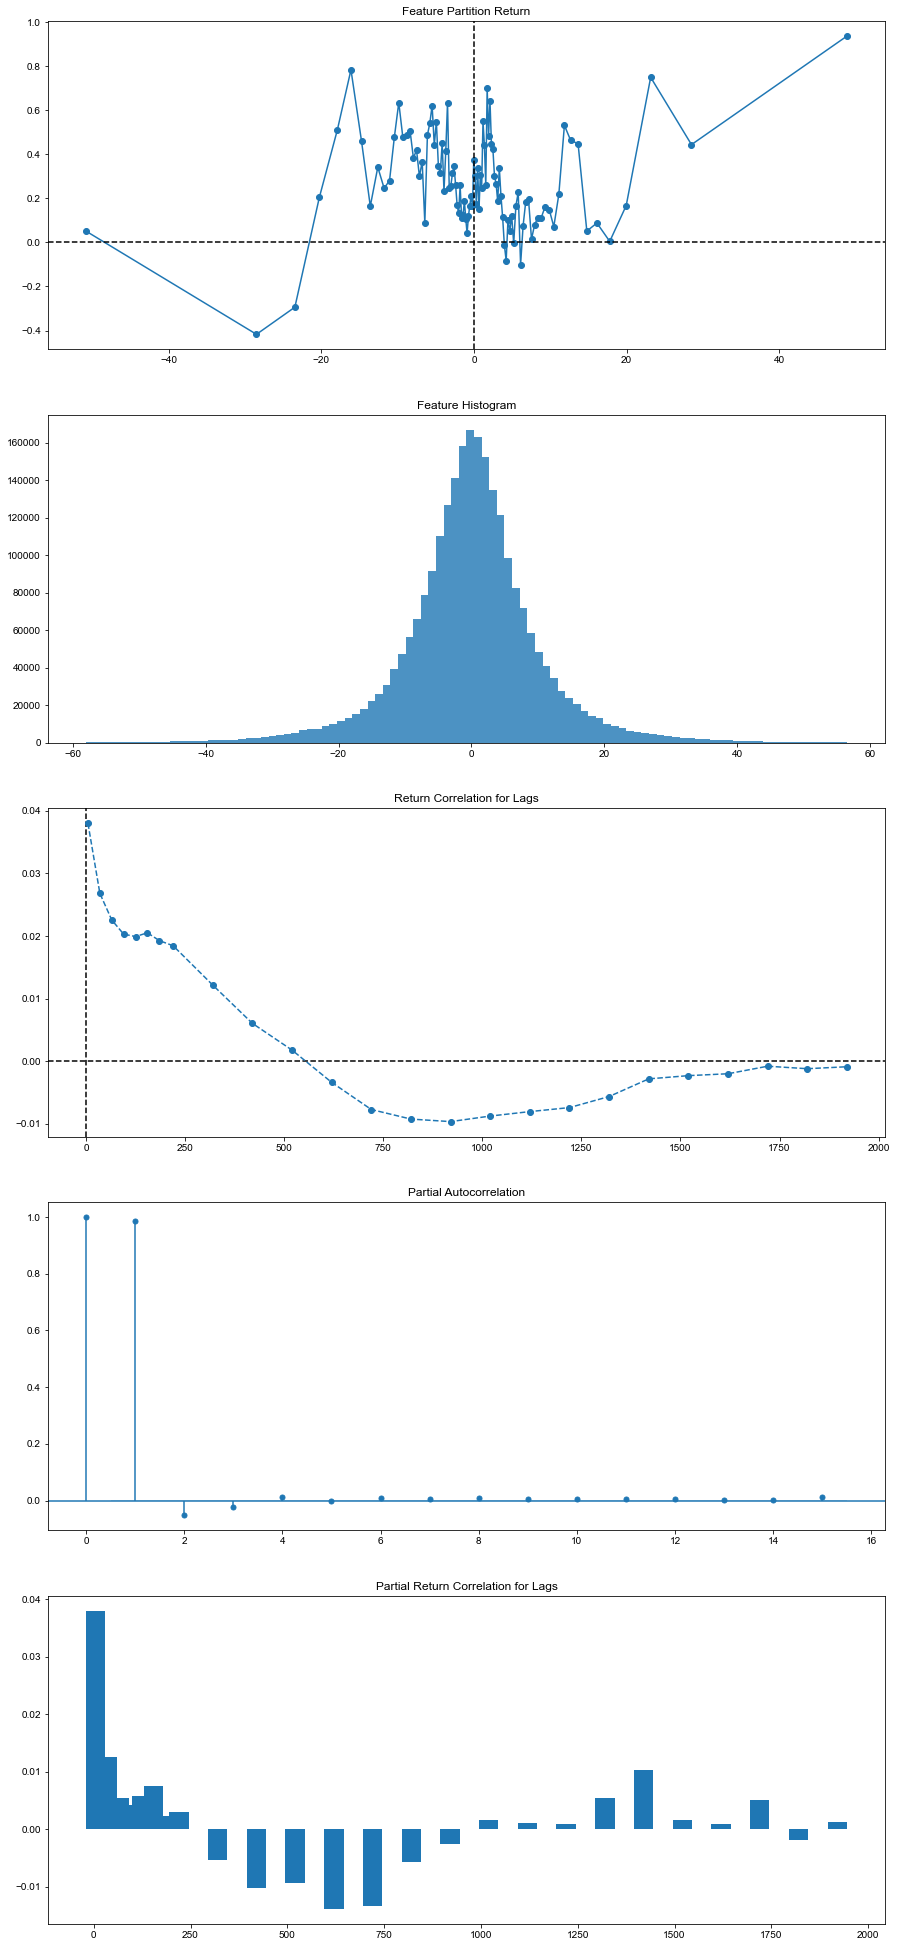

In [28]:
plot_stats({"datas":{"orderbook":ob},"feature":bv})

## 因子测试

##### 测试因子1：tpap_diff

In [29]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_average(x):
    cnt=0
    sum_x=0
    for i in range(len(x)):
        cnt+=1
        sum_x+=x[i]
    return sum_x/cnt

@trade_to_depth
def tpap_diff(depth5, trade, n=100):
    return (trade.p.rolling(n).apply(get_average,engine='numba',raw=True) - trade.p).fillna(0)

In [30]:
td=tpap_diff(depth5=ob,trade=tr,n=20)

In [31]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(td, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(td, mid_price.diff(500).shift(-500).fillna(0)))
#

(-0.005991483455183731, 1.832994832908466e-21)
SpearmanrResult(correlation=-0.013967296794105494, pvalue=5.350150257480228e-109)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

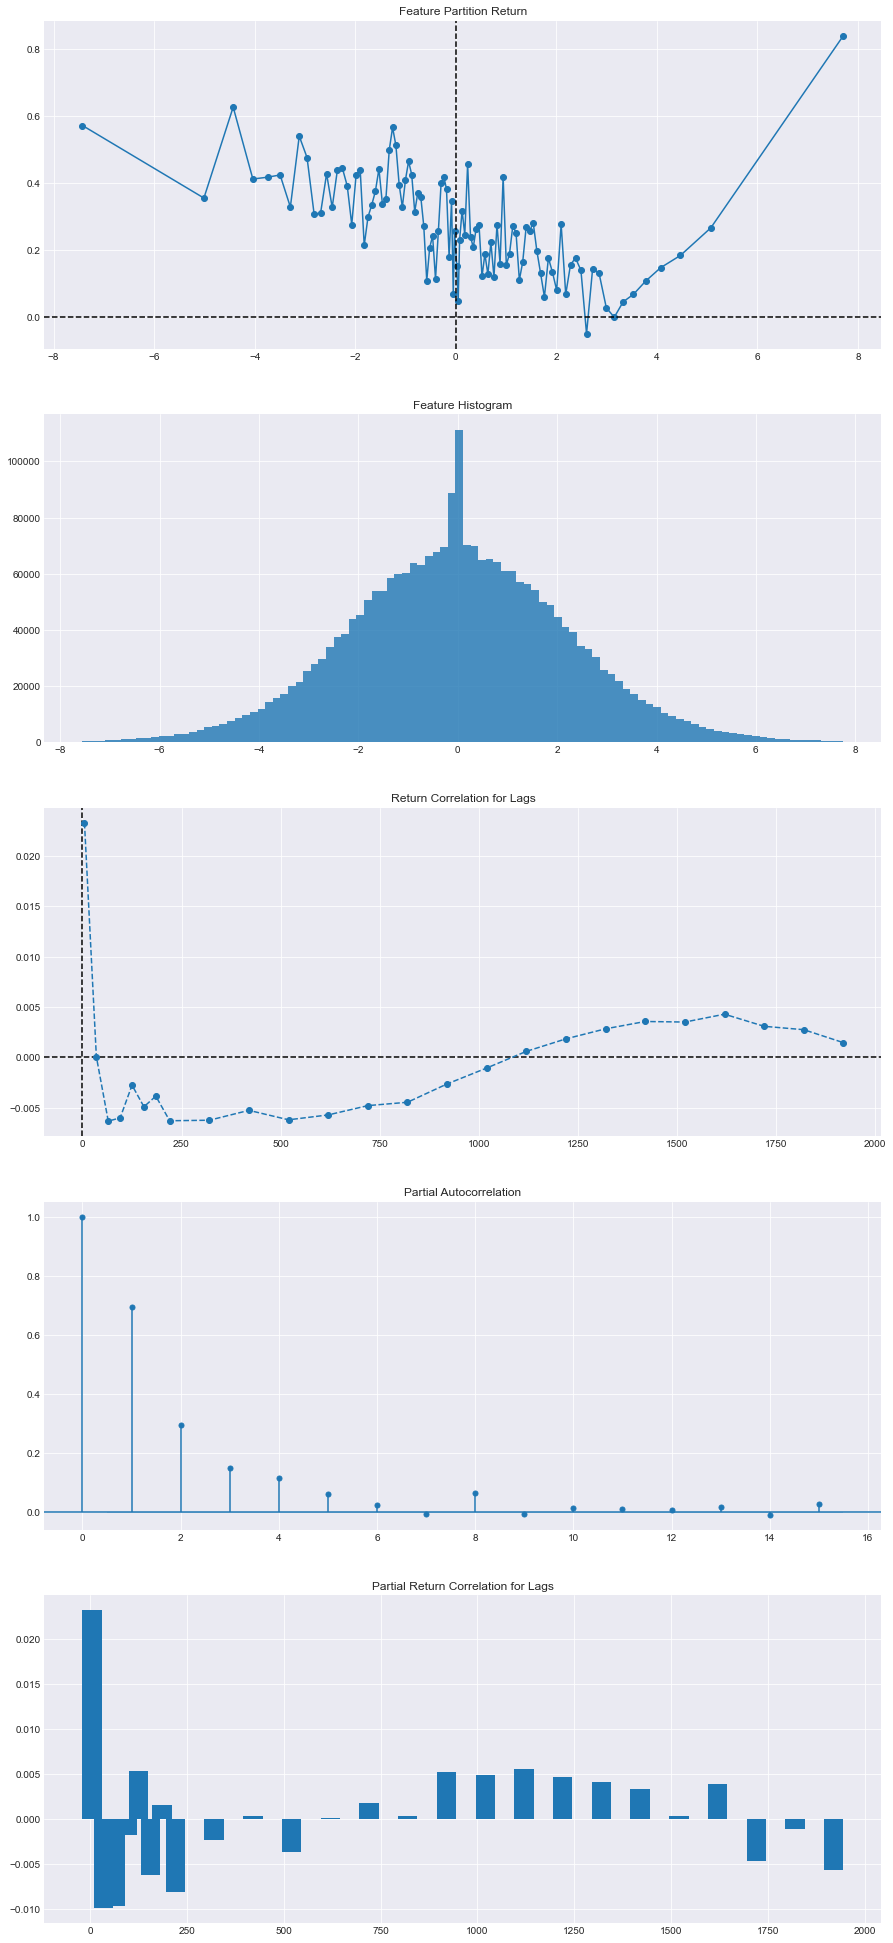

In [32]:
plot_stats({"datas":{"orderbook":ob},"feature":td})

##### 测试因子2：pos_neg_diff

In [33]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_pos_neg_diff(x):
    pos = 0
    neg = 0
    for i in range(len(x)):
        if x[i]>=0:
            pos+=1
        else:
            neg+=1
    return pos-neg

@trade_to_depth
def pos_neg_diff(depth5, trade, n=100):
    return trade.v.rolling(n).apply(get_pos_neg_diff,engine='numba',raw=True).fillna(0)

In [34]:
pnd=pos_neg_diff(depth5=ob,trade=tr,n=15)

In [35]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(pnd, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(pnd, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":pnd})

(0.0025614912059187317, 4.752920075453571e-05)
SpearmanrResult(correlation=-0.0023572565905806532, pvalue=0.00018173077629154587)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

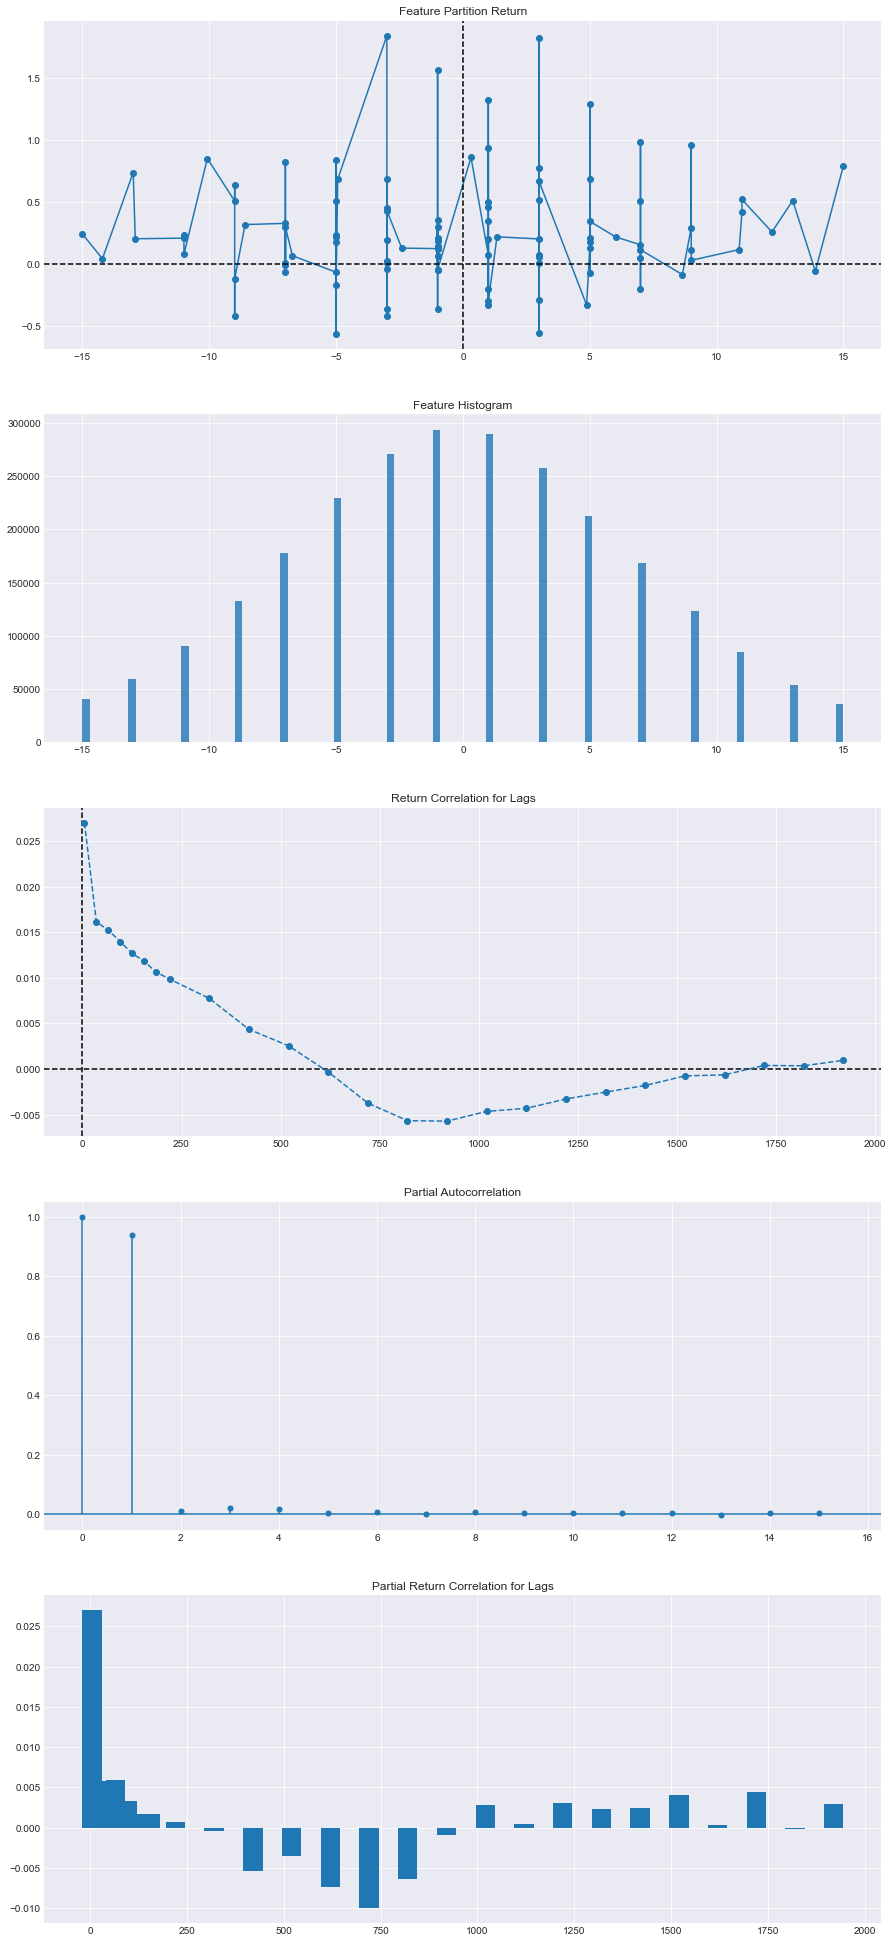

In [36]:
plot_stats({"datas":{"orderbook":ob},"feature":pnd})

##### 测试因子3：pos_neg_diff_p

In [37]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_pos_neg_diff_p(x):
    pos = 0
    neg = 0
    for i in range(len(x)):
        if x[i]>=0:
            pos+=x[i]
        else:
            neg+=x[i]
    return pos+neg

@trade_to_depth
def pos_neg_diff_p(depth5, trade, n=100):
    return (trade.v*trade.p).rolling(n).apply(get_pos_neg_diff_p,engine='numba',raw=True).fillna(0)

In [38]:
pndp=pos_neg_diff_p(depth5=ob,trade=tr,n=20)

In [39]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(pndp, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(pndp, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":pndp})

(0.0050742157949874075, 7.786249879932235e-16)
SpearmanrResult(correlation=-0.006646843249514512, pvalue=4.8272926799122464e-26)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

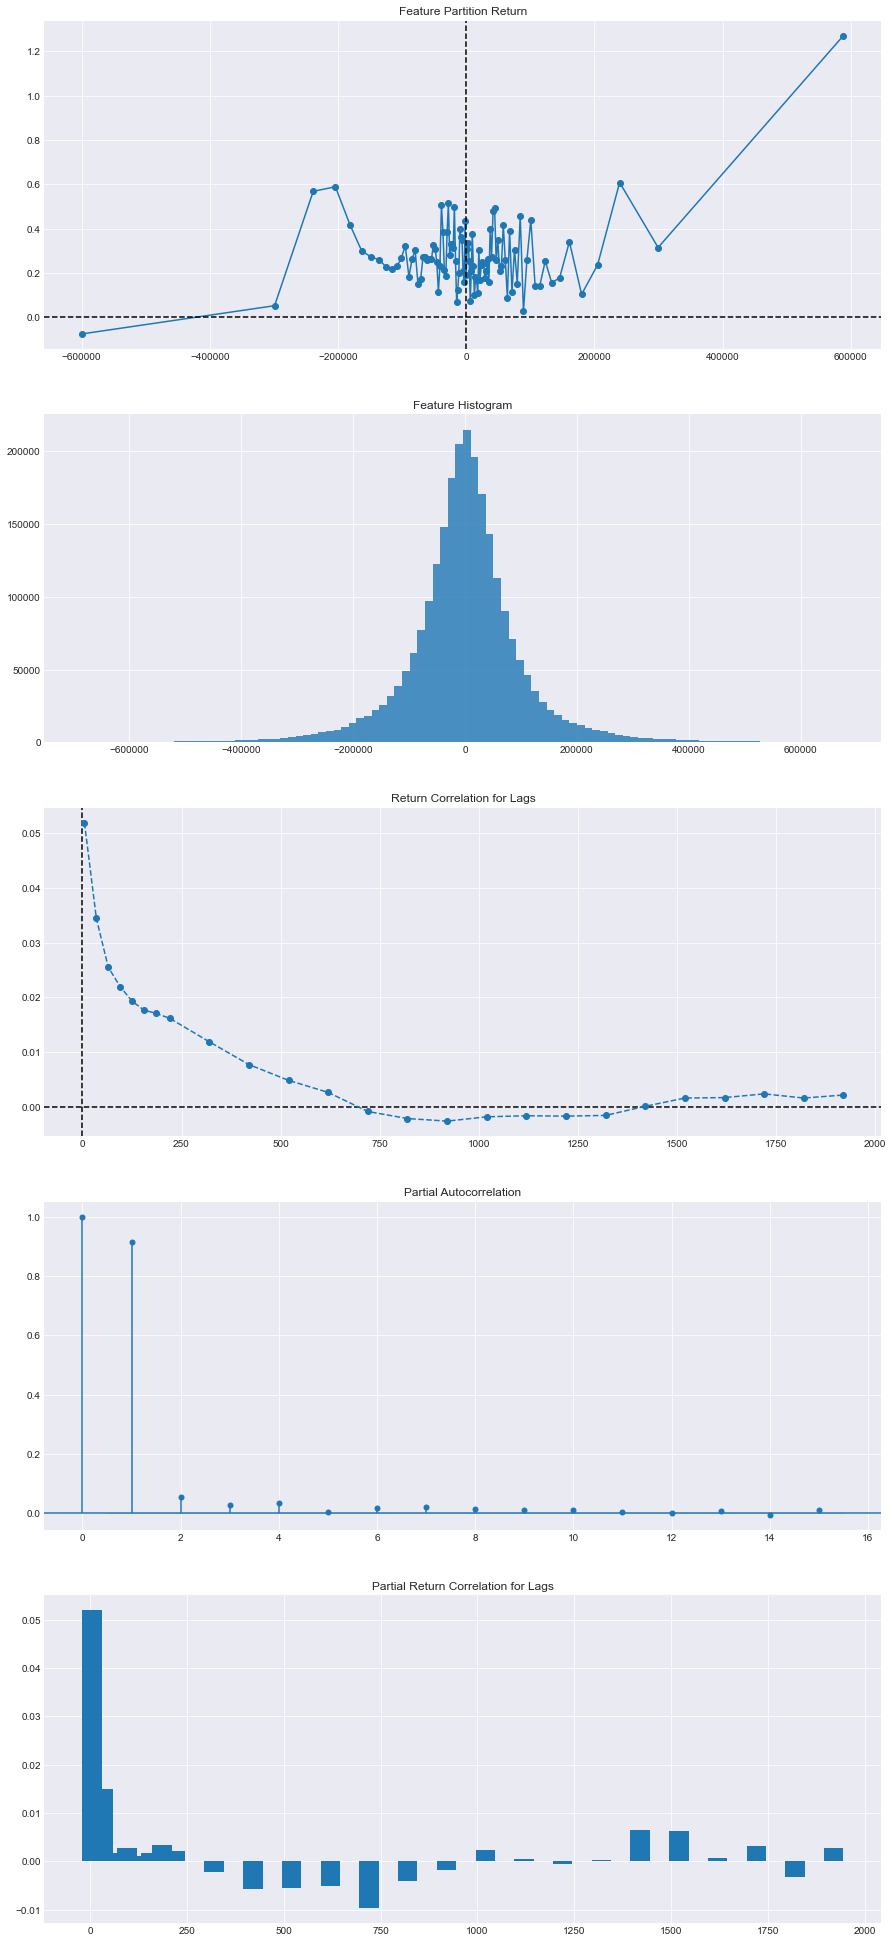

In [40]:
plot_stats({"datas":{"orderbook":ob},"feature":pndp})

##### 测试因子4：pv_diff

In [41]:
from hft.utils.wrapper import trade_to_depth

@trade_to_depth
def pv_diff(depth5, trade, n=100):
    return (trade.v*trade.p).diff(n).fillna(0)

In [42]:
pvd=pv_diff(depth5=ob,trade=tr,n=1)

In [43]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(pvd, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(pvd, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":pvd})

(-0.0029689606142108108, 2.4231760975156884e-06)
SpearmanrResult(correlation=0.00012370747894739682, pvalue=0.8442674531686782)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

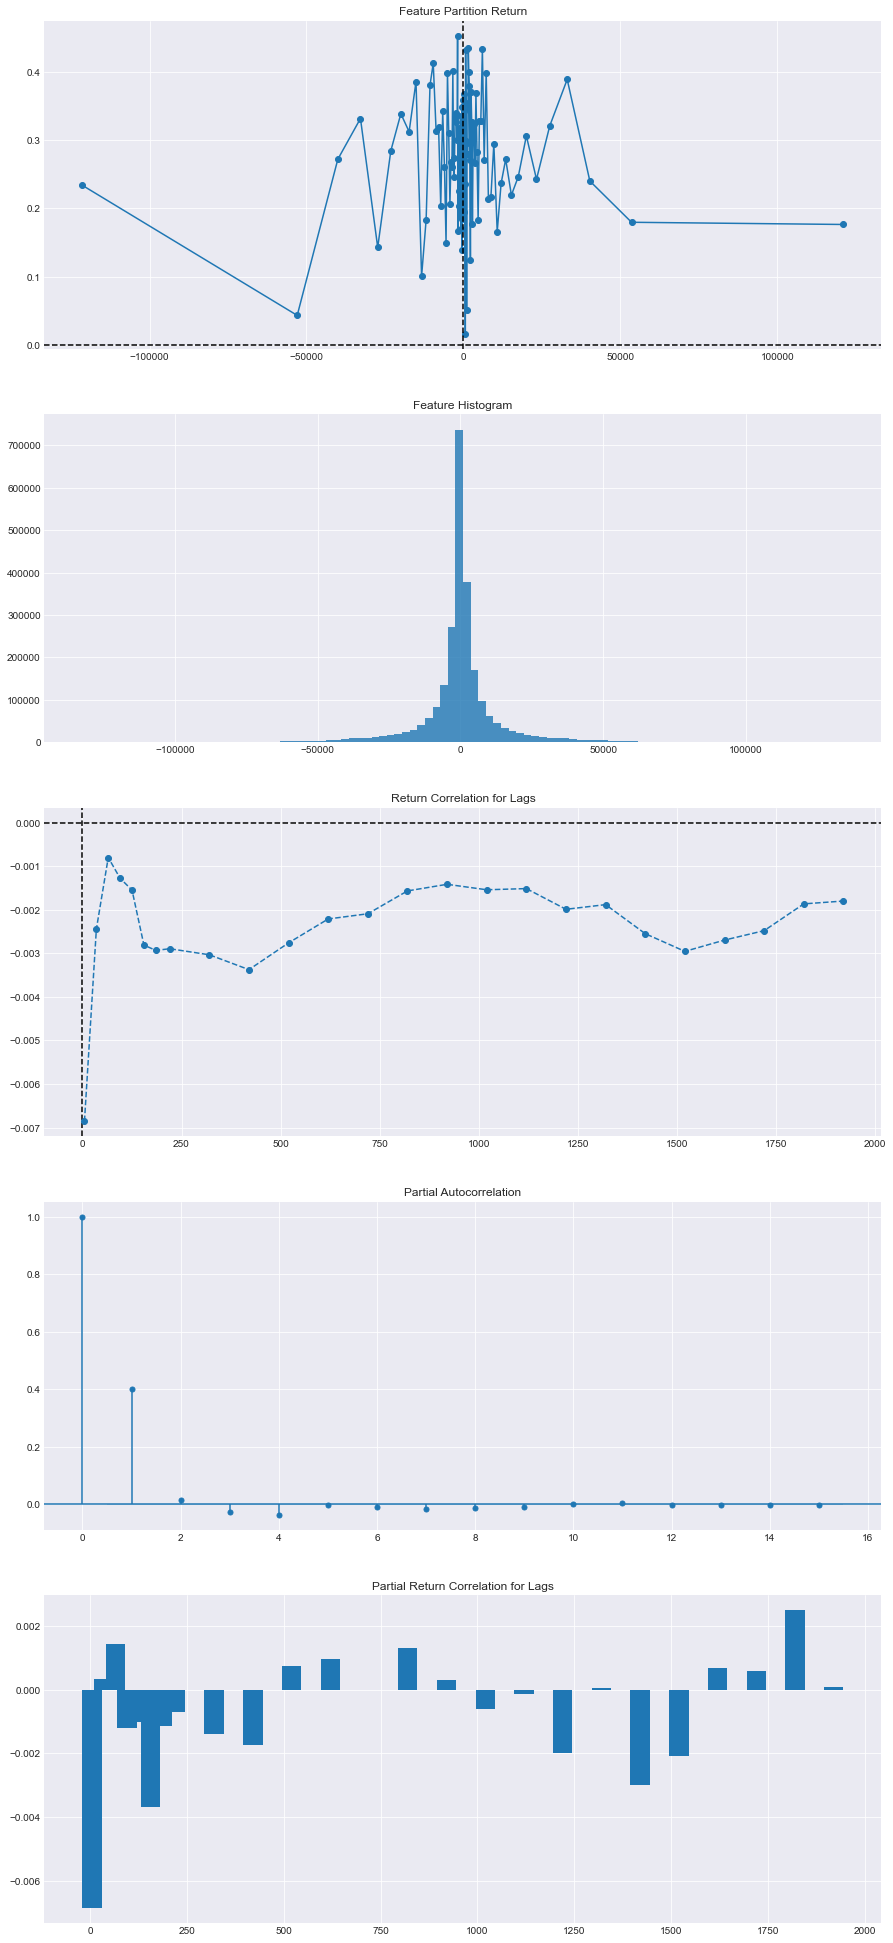

In [44]:
plot_stats({"datas":{"orderbook":ob},"feature":pvd})

##### 测试因子5：tpap_diff_mean

In [45]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_average(x):
    cnt=0
    sum_x=0
    for i in range(len(x)):
        cnt+=1
        sum_x+=x[i]
    return sum_x/cnt

@trade_to_depth
def tpap_diff_average(depth5, trade, n=100):
    td=(trade.p.rolling(n).apply(get_average,engine='numba',raw=True) - trade.p).fillna(0)
    return td.rolling(n).apply(get_average,engine='numba',raw=True).fillna(0)

In [46]:
tda=tpap_diff_average(depth5=ob,trade=tr,n=15)

In [47]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(tda, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(tda, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":tda})

(-0.00668620804329628, 2.476248800562387e-26)
SpearmanrResult(correlation=-0.00853706266365296, pvalue=7.257388370241728e-42)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

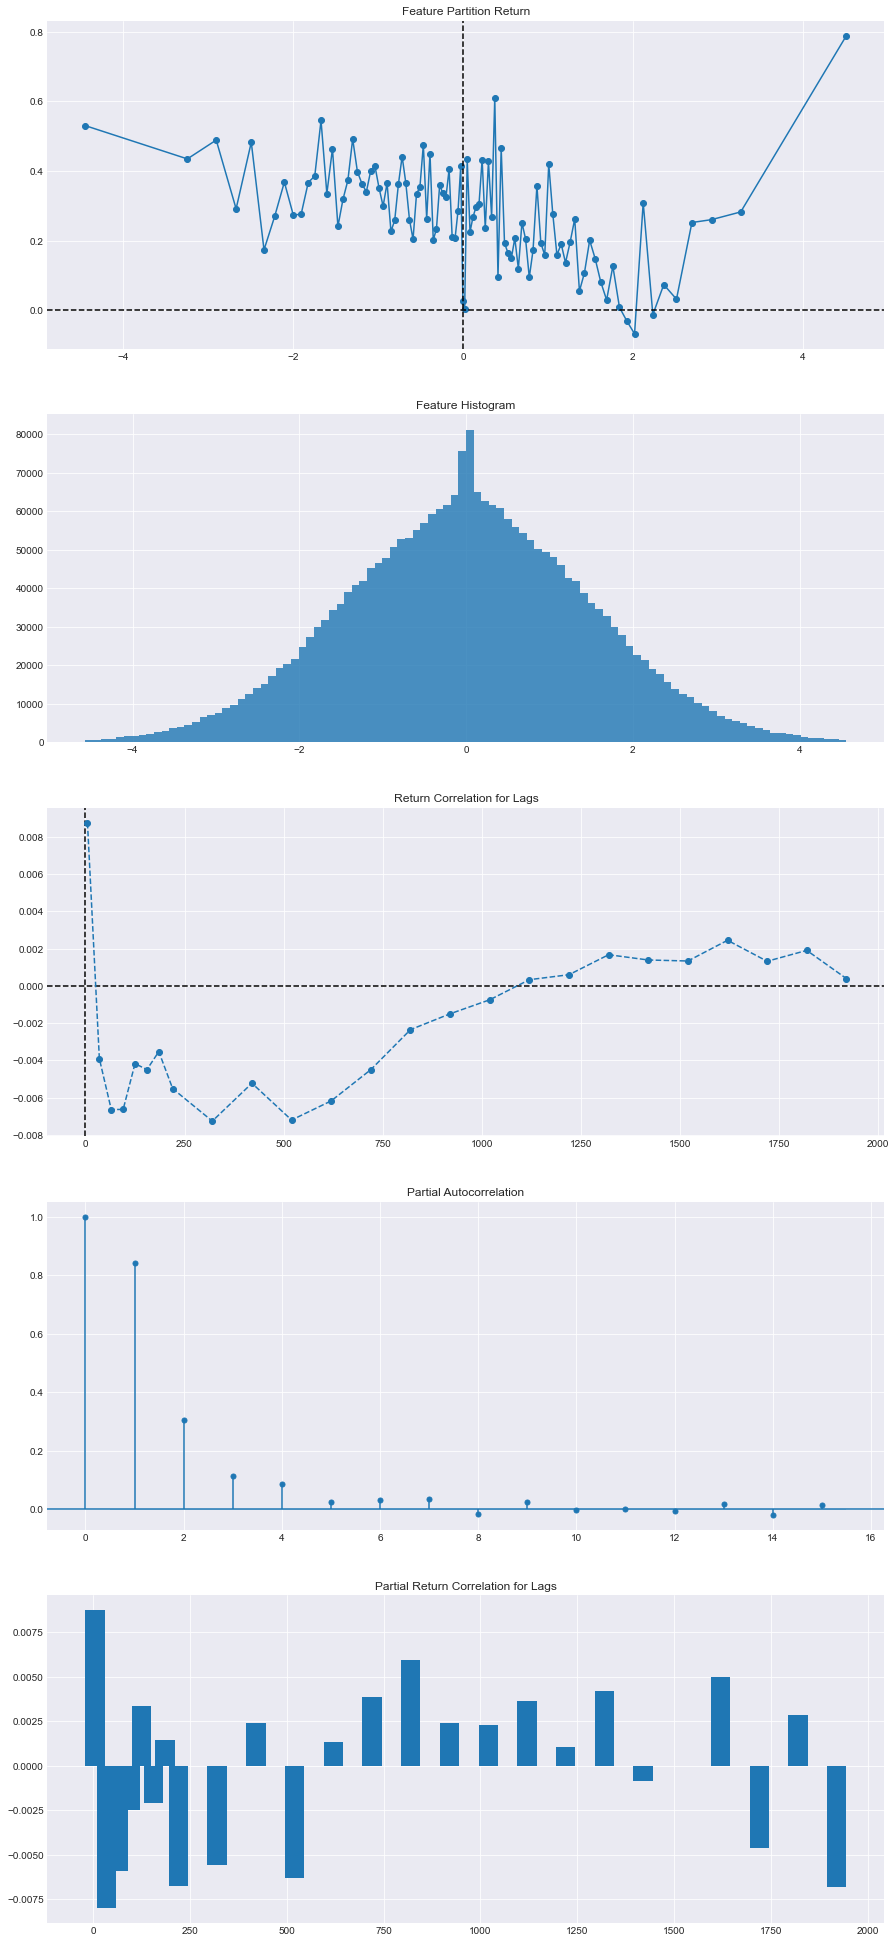

In [48]:
plot_stats({"datas":{"orderbook":ob},"feature":tda})

##### 测试因子6：tpap_mean_diff2

In [49]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_average(x):
    cnt=0
    sum_x=0
    for i in range(len(x)):
        cnt+=1
        sum_x+=x[i]
    return sum_x/cnt

@trade_to_depth
def tpap_mean_diff2(depth5, trade, n=100):
    td=(trade.p.rolling(n).apply(get_average,engine='numba',raw=True) - trade.p).fillna(0)
    return td-td.rolling(n).apply(get_average,engine='numba',raw=True).fillna(0)

In [50]:
tmd=tpap_mean_diff2(depth5=ob,trade=tr,n=30)

In [51]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(tmd, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(tmd, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":tmd})

(-2.3983291305822337e-05, 0.9696199608923181)
SpearmanrResult(correlation=-0.007153846729610036, pvalue=6.622137745174277e-30)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

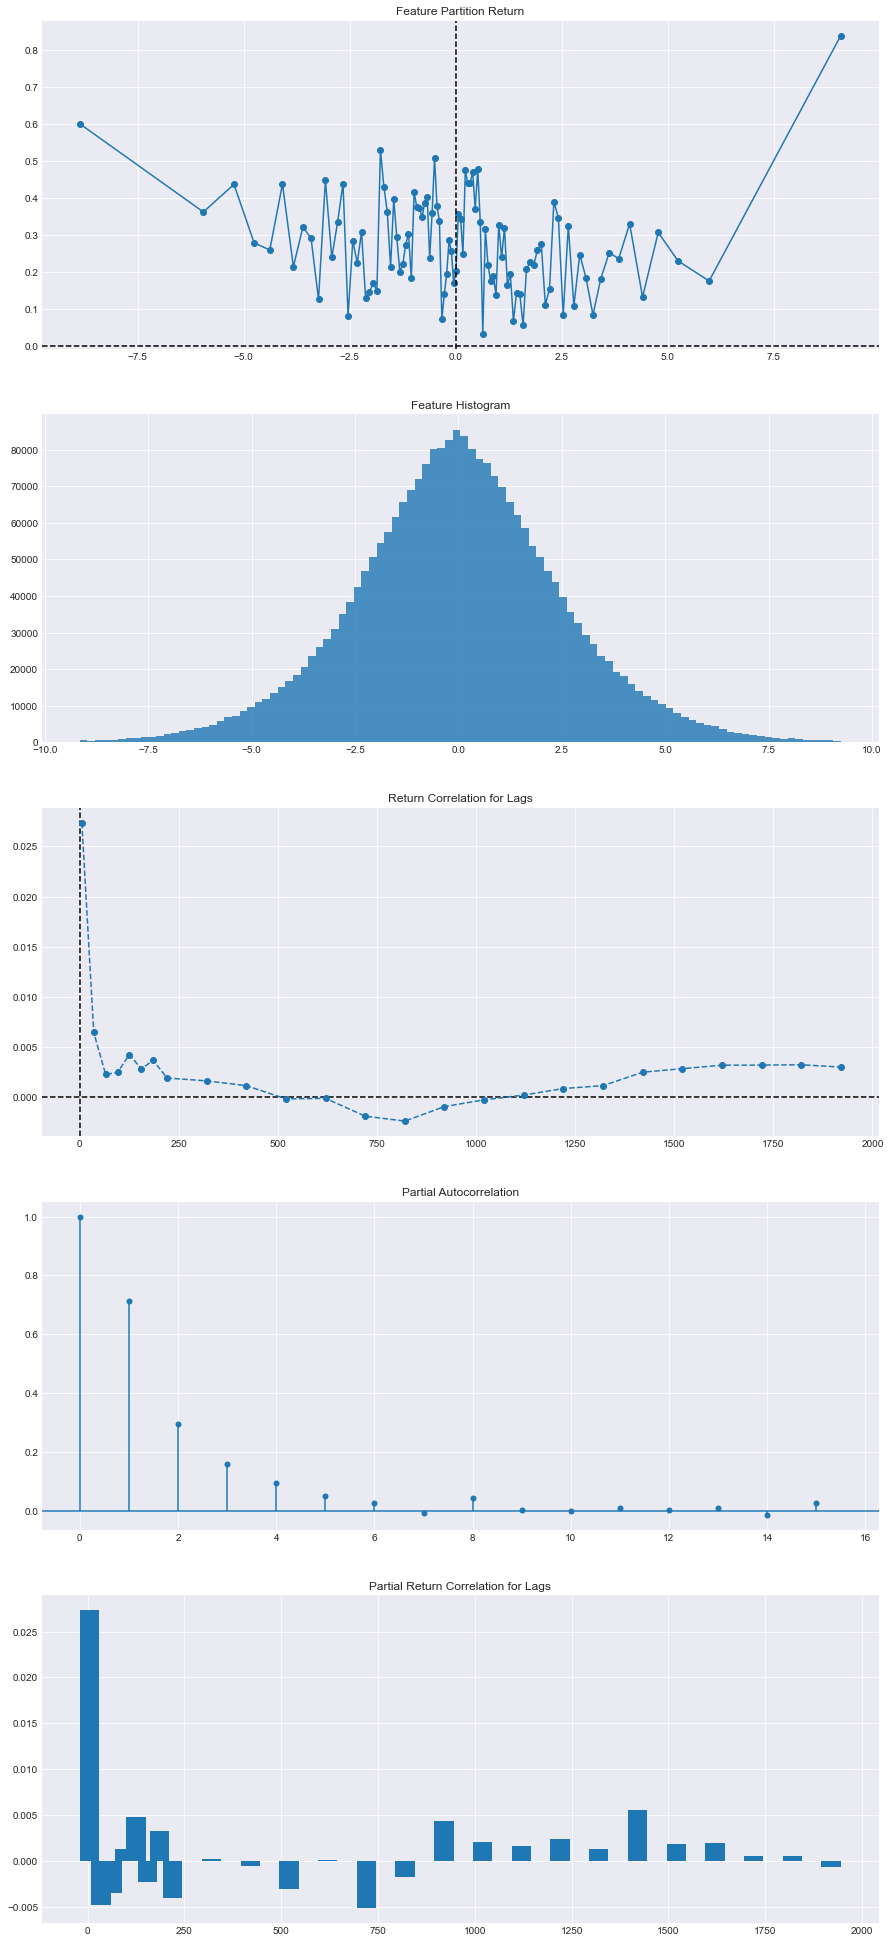

In [52]:
plot_stats({"datas":{"orderbook":ob},"feature":tmd})

##### 测试因子7：pv_diff_mean

In [53]:
from hft.utils.wrapper import trade_to_depth
import numba as nb

@nb.jit
def get_average(x):
    cnt=0
    sum_x=0
    for i in range(len(x)):
        cnt+=1
        sum_x+=x[i]
    return sum_x/cnt

@trade_to_depth
def pv_diff_mean(depth5, trade, n=100):
    pd=(trade.v*trade.p).diff().fillna(0)
    return pd.rolling(n).apply(get_average,engine='numba',raw=True).fillna(0)

In [54]:
pdm=pv_diff_mean(depth5=ob,trade=tr,n=20)

In [55]:
mid_price = (ob.ap1 + ob.bp1)/2
print(pearsonr(pdm, mid_price.diff(500).shift(-500).fillna(0)))
print(spearmanr(pdm, mid_price.diff(500).shift(-500).fillna(0)))
#plot_stats({"datas":{"orderbook":ob},"feature":tmd})

(0.000983922552471391, 0.11819543023662901)
SpearmanrResult(correlation=0.003094417538018054, pvalue=8.937044422274447e-07)


(<Figure size 1080x2520 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Feature Partition Return'}>,
        <AxesSubplot:title={'center':'Feature Histogram'}>,
        <AxesSubplot:title={'center':'Return Correlation for Lags'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Return Correlation for Lags'}>],
       dtype=object))

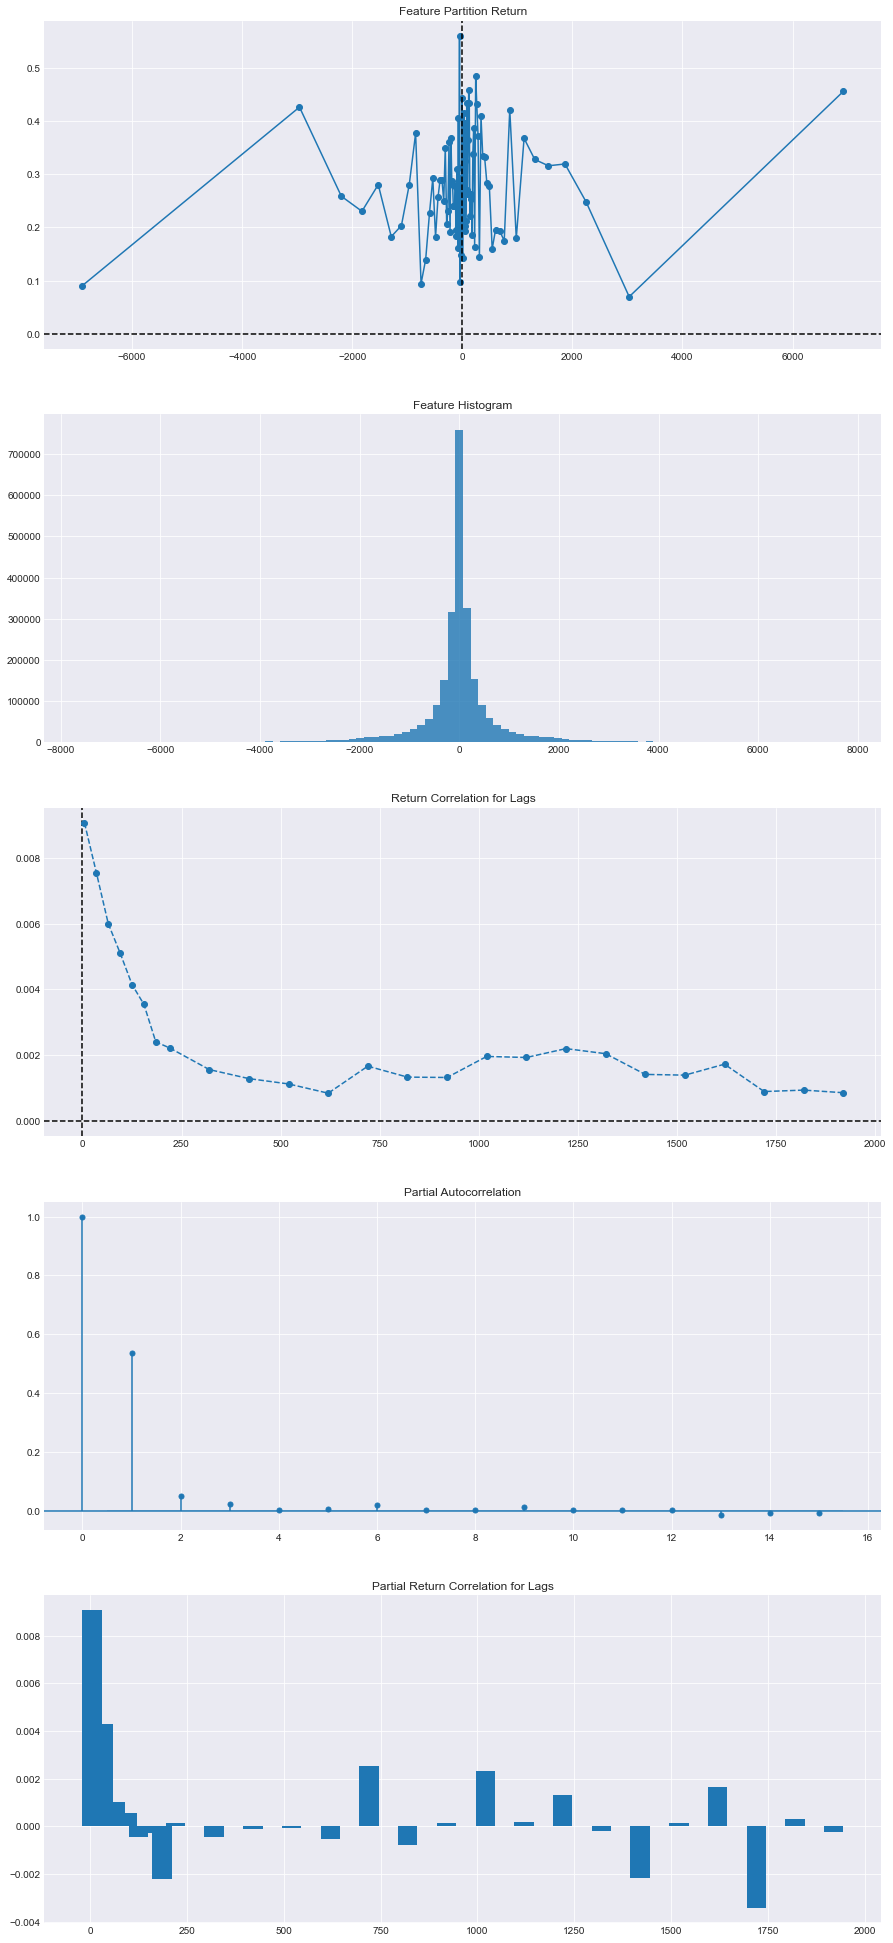

In [56]:
plot_stats({"datas":{"orderbook":ob},"feature":pdm})

### 因子度量指标